# l2-orderbook example usage

In [1]:
import logging
import os

logging.basicConfig(level=os.environ.get("LOGLEVEL", "INFO"))

In [2]:
from scipy import stats

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import plb

In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', None)

In [7]:
%matplotlib inline

In [8]:
INPUT_DIR='/storage/m2/market_data/raw/crypto/binance/BTCUSDT/orderbook'
OUTPUT_PQ='output2.parquet'
SAMPLE_DATE='2020-11-01'

In [9]:
def get_input_pair(input_dir, dt):
    '''Load Binance L2 orderbook snapshot and delta files'''
    fn_template = os.path.join(input_dir, 'BTCUSDT_T_DEPTH_{}_depth_'.format(dt))
    snap_fn = fn_template + 'snap.csv'
    update_fn = fn_template + 'update.csv'
    
    return pd.read_csv(snap_fn), pd.read_csv(update_fn)

In [10]:
def get_l2_input(input_dir, dt):
    '''Pre-process input'''
    snapshot, deltas = get_input_pair(input_dir, dt)
    
    df = pd.concat([snapshot,deltas])

    df['side'] = np.where(df['side'] == 'b', 1, 0)
    df['side'] = df['side'].astype('int8')

    df['qty'] = df['qty'].astype('float32')

    df = df.drop(columns=['symbol', 'first_update_id', 'last_update_id', 'update_type'])
    
    return df, snapshot.shape[0]

In [11]:
def get_tops(input_dir, dt, tops_n=8, total_dollar_depth=0):
    l2_input_df, snapshot_end_offset = get_l2_input(input_dir, dt)
    
    data = l2_input_df[['timestamp', 'side', 'price', 'qty']].values
    ret = plb.l2_walk(data[:,0].astype(int), data[:,1].astype(int), data[:,2], data[:,3])
    
    ret = ret.iloc[snapshot_end_offset:]
    
    ret['ts'] = pd.to_datetime(ret['ts'], unit='ms')

    ret['year'] = ret.ts.dt.year
    ret['month'] = ret.ts.dt.month
    ret['day'] = ret.ts.dt.day
    
    ret = ret.set_index(ret['ts'])

    return ret

In [12]:
ret = get_tops(INPUT_DIR, SAMPLE_DATE, total_dollar_depth=100)

## EDA

In [13]:
ret.head()

,ts,b_0,bq_0,b_1,bq_1,b_2,bq_2,b_3,bq_3,b_4,bq_4,b_5,bq_5,b_6,bq_6,b_7,bq_7,a_0,aq_0,a_1,aq_1,a_2,aq_2,a_3,aq_3,a_4,aq_4,a_5,aq_5,a_6,aq_6,a_7,aq_7,b_total,a_total,year,month,day
ts,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-01 00:00:22.013,2020-11-01 00:00:22.013,13758.95,1.375,13758.8,0.04,13758.12,0.501,13757.54,0.309,13757.53,0.1,13757.52,0.121,13757.49,0.16,13757.48,0.1,13759.06,5.200,13759.42,2.0,13759.74,3.385,13759.75,4.475,13760.54,0.884,13760.56,0.002,13760.61,1.353,13760.81,0.101,0.0,0.0,2020,11,1
2020-11-01 00:00:22.025,2020-11-01 00:00:22.025,13758.95,1.375,13758.8,0.04,13758.12,0.501,13757.54,0.309,13757.53,0.1,13757.52,0.121,13757.49,0.16,13757.48,0.1,13758.96,0.309,13759.06,5.2,13759.42,2.000,13759.74,3.385,13759.75,4.475,13760.54,0.884,13760.56,0.002,13760.61,1.353,0.0,0.0,2020,11,1
2020-11-01 00:00:22.025,2020-11-01 00:00:22.025,13758.95,1.375,13758.8,0.04,13758.12,0.501,13757.54,0.309,13757.53,0.1,13757.52,0.121,13757.49,0.16,13757.48,0.1,13758.96,0.309,13759.06,5.2,13759.42,2.000,13759.74,3.385,13759.75,4.416,13760.54,0.884,13760.56,0.002,13760.61,1.353,0.0,0.0,2020,11,1
2020-11-01 00:00:22.026,2020-11-01 00:00:22.026,13758.95,1.375,13758.8,0.04,13758.12,0.501,13757.54,0.309,13757.53,0.1,13757.52,0.121,13757.49,0.16,13757.48,0.1,13758.96,0.309,13759.06,5.2,13759.42,2.000,13759.74,4.283,13759.75,4.416,13760.54,0.884,13760.56,0.002,13760.61,1.353,0.0,0.0,2020,11,1
2020-11-01 00:00:22.026,2020-11-01 00:00:22.026,13758.95,1.375,13758.8,0.04,13758.12,0.501,13757.54,0.309,13757.53,0.1,13757.52,0.121,13757.49,0.16,13757.48,0.1,13758.96,0.368,13759.06,5.2,13759.42,2.000,13759.74,4.283,13759.75,4.416,13760.54,0.884,13760.56,0.002,13760.61,1.353,0.0,0.0,2020,11,1


In [14]:
ret['spread']  = ret['a_0'] - ret['b_0']
ret['mid_price'] = ret['b_0'] + ret['spread']

In [15]:
ret['b_qty'] = ret[[c for c in ret.columns if c.startswith('bq_')]].sum(axis=1)
ret['a_qty'] = ret[[c for c in ret.columns if c.startswith('aq_')]].sum(axis=1)
ret['tops_imbalance_delta'] = ((ret['b_qty'] - ret['a_qty']) )

In [16]:
sample = ret.tail(100000)

In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 3

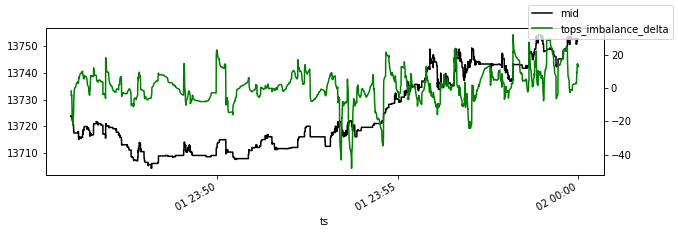

In [18]:
ax = sample['mid_price'].plot(label='mid', color='black')

ax2 = ax.twinx()
sample['tops_imbalance_delta'].ewm(500).mean().plot(ax=ax2, color='green')

ax.figure.legend()
plt.show()